# Interacting with APIs

## Use case 

---

Suppose you want an LLM to interact with external APIs.

This can be very useful for retrieving useful context for the LLM to utilize.

And, more generally, it allows us to interact with APIs using natural langugage! 
 

## Overview

---

There are two primary ways to interface LLMs with external APIs:
 
* `OpenAI`: [OpenAI functions](https://platform.openai.com/docs/guides/gpt/function-calling) is one popular means of doing this and supports many APIs.
* `APIChain`: Customize LLM interface with an external API.

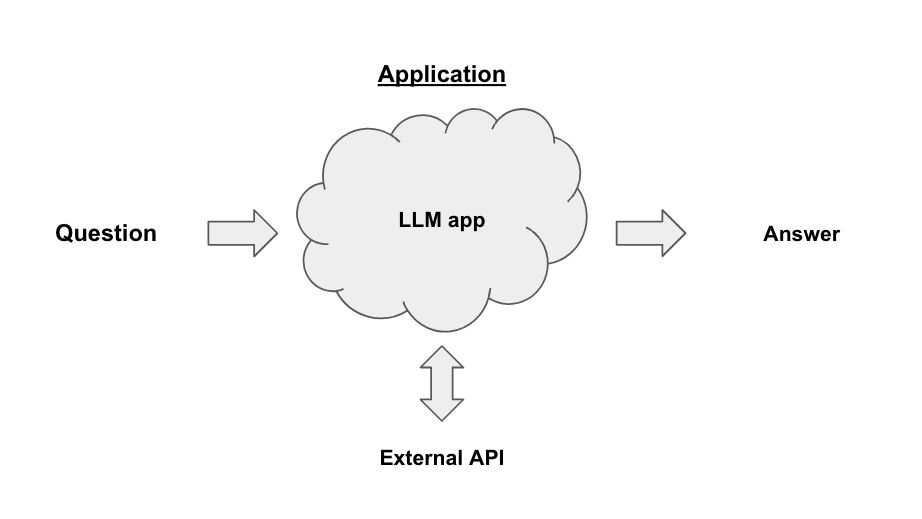

## Quickstart 

---

Many APIs already are integrated with OpenAI function calling and have API specifications.

For example, [Klarna](https://www.klarna.com/international/press/klarna-brings-smoooth-shopping-to-chatgpt/) has a YAML file that describes its API and allows OpenAI to interact with it:

```
https://www.klarna.com/us/shopping/public/openai/v0/api-docs/
```

Other options include:

* [Speak](https://api.speak.com/openapi.yaml) for translation
* [XKCD](https://gist.githubusercontent.com/roaldnefs/053e505b2b7a807290908fe9aa3e1f00/raw/0a212622ebfef501163f91e23803552411ed00e4/openapi.yaml) for comics

We can supply the specification to `get_openapi_chain` directly in order to query the API with OpenAI functions:

In [44]:
from langchain.chains.openai_functions.openapi import get_openapi_chain
chain = get_openapi_chain("https://www.klarna.com/us/shopping/public/openai/v0/api-docs/")
chain("What are some options for a men's large blue button down shirt")

Attempting to load an OpenAPI 3.0.1 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.


{'query': "What are some options for a men's large blue button down shirt",
 'response': {'products': [{'name': 'Cubavera Four Pocket Guayabera Shirt',
    'url': 'https://www.klarna.com/us/shopping/pl/cl10001/3202055522/Clothing/Cubavera-Four-Pocket-Guayabera-Shirt/?utm_source=openai&ref-site=openai_plugin',
    'price': '$24.99',
    'attributes': ['Material:Polyester,Cotton',
     'Target Group:Man',
     'Color:Red,White,Blue,Black',
     'Properties:Pockets',
     'Pattern:Solid Color',
     'Size:S,XL,L,M,XXL']},
   {'name': 'Brixton Bowery Flannel Shirt',
    'url': 'https://www.klarna.com/us/shopping/pl/cl10001/3202331096/Clothing/Brixton-Bowery-Flannel-Shirt/?utm_source=openai&ref-site=openai_plugin',
    'price': '$38.48',
    'attributes': ['Material:Cotton',
     'Target Group:Man',
     'Color:Gray,Blue,Black,Orange',
     'Properties:Pockets',
     'Pattern:Checkered',
     'Size:XL,3XL,4XL,5XL,L,M,XXL']},
   {'name': 'Vineyard Vines Gingham On-The-Go brrr Classic Fit Shi

## OpenAI 

---

We can unpack what is hapening when we use the OpenAI funtions to calls external APIs.

First, we're parsing the OpenAPI spec into a JSON schema that the OpenAI functions API can handle.

In [20]:
from langchain.tools import OpenAPISpec
spec = OpenAPISpec.from_url(
    "https://www.klarna.com/us/shopping/public/openai/v0/api-docs/"
)

Attempting to load an OpenAPI 3.0.1 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.


Create a chain specifically only for one of the endpoints. 

Here we get an API operation from a specified endpoint and method.

In [21]:
from langchain.tools import APIOperation
operation = APIOperation.from_openapi_spec(spec, "/public/openai/v0/products", "get")

In [22]:
from langchain.chains import OpenAPIEndpointChain
from langchain.requests import Requests
from langchain.llms import OpenAI
llm = OpenAI()  
chain = OpenAPIEndpointChain.from_api_operation(
    operation,
    llm,
    requests=Requests(),
    verbose=True,
    return_intermediate_steps=True,  # Return request and response text
)

In [23]:
output = chain("whats the most expensive shirt?")



> Entering new OpenAPIEndpointChain chain...


> Entering new APIRequesterChain chain...
Prompt after formatting:
You are a helpful AI Assistant. Please provide JSON arguments to agentFunc() based on the user's instructions.

API_SCHEMA: ```typescript
/* API for fetching Klarna product information */
type productsUsingGET = (_: {
/* ISO 3166 country code with 2 characters based on the user location. Currently, only US, GB, DE, SE and DK are supported. */
		countryCode: string,
/* A precise query that matches one very small category or product that needs to be searched for to find the products the user is looking for. If the user explicitly stated what they want, use that as a query. The query is as specific as possible to the product name or category mentioned by the user in its singular form, and don't contain any clarifiers like latest, newest, cheapest, budget, premium, expensive or similar. The query is always taken from the latest topic, if there is a new topic a new query is st

The answer is synthesized in the output:

In [25]:
output['output']

'The most expensive shirt from the API_RESPONSE is the Casablanca Pink Rainbow Monogram Shirt at $551.00.'

### Go Deeper

* If we do not want the answer synthesized, we can use `raw_response=True`
* Different operations, such as `POST` requests can be done as shown below

In [ ]:
spec = OpenAPISpec.from_url("https://api.speak.com/openapi.yaml")

In [27]:
operation = APIOperation.from_openapi_spec(
    spec, "/v1/public/openai/explain-task", "post"
)

In [28]:
llm = OpenAI()
chain = OpenAPIEndpointChain.from_api_operation(
    operation, llm, requests=Requests(), verbose=True, return_intermediate_steps=True
)

In [ ]:
output = chain("How would ask for more tea in Delhi?")

## API Chain 

---

We can also build our own interface to external APIs using the `APIChain` and provided API documentation.

In [32]:
from langchain.chains import APIChain
from langchain.chains.api import open_meteo_docs
llm = OpenAI(temperature=0)
chain = APIChain.from_llm_and_api_docs(llm, open_meteo_docs.OPEN_METEO_DOCS, verbose=True)
chain.run('What is the weather like right now in Munich, Germany in degrees Fahrenheit?')



> Entering new APIChain chain...
https://api.open-meteo.com/v1/forecast?latitude=48.1351&longitude=11.5820&hourly=temperature_2m&temperature_unit=fahrenheit&current_weather=true
{"latitude":48.14,"longitude":11.58,"generationtime_ms":0.17201900482177734,"utc_offset_seconds":0,"timezone":"GMT","timezone_abbreviation":"GMT","elevation":521.0,"current_weather":{"temperature":66.1,"windspeed":7.4,"winddirection":223.0,"weathercode":3,"is_day":0,"time":"2023-07-31T21:00"},"hourly_units":{"time":"iso8601","temperature_2m":"°F"},"hourly":{"time":["2023-07-31T00:00","2023-07-31T01:00","2023-07-31T02:00","2023-07-31T03:00","2023-07-31T04:00","2023-07-31T05:00","2023-07-31T06:00","2023-07-31T07:00","2023-07-31T08:00","2023-07-31T09:00","2023-07-31T10:00","2023-07-31T11:00","2023-07-31T12:00","2023-07-31T13:00","2023-07-31T14:00","2023-07-31T15:00","2023-07-31T16:00","2023-07-31T17:00","2023-07-31T18:00","2023-07-31T19:00","2023-07-31T20:00","2023-07-31T21:00","2023-07-31T22:00","2023-07-31T23:

' The current temperature in Munich, Germany is 66.1°F.'

Note that we supply information about the API:

In [37]:
open_meteo_docs.OPEN_METEO_DOCS[0:500]

'BASE URL: https://api.open-meteo.com/\n\nAPI Documentation\nThe API endpoint /v1/forecast accepts a geographical coordinate, a list of weather variables and responds with a JSON hourly weather forecast for 7 days. Time always starts at 0:00 today and contains 168 hours. All URL parameters are listed below:\n\nParameter\tFormat\tRequired\tDefault\tDescription\nlatitude, longitude\tFloating point\tYes\t\tGeographical WGS84 coordinate of the location\nhourly\tString array\tNo\t\tA list of weather variables which shou'

Under the hood, we do two things:
    
* `api_request_chain`: Generate an API URL based on the input question and the api_docs
* `api_answer_chain`: generate a final answer based on the API response

We can see the [prompt](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/api/prompt.py) for `api_request_chain` simply uses the documentation to formulate the API call:

```
API_URL_PROMPT_TEMPLATE = """You are given the below API Documentation:
{api_docs}
Using this documentation, generate the full API url to call for answering the user question.
You should build the API url in order to get a response that is as short as possible, while still getting the necessary information to answer the question. Pay attention to deliberately exclude any unnecessary pieces of data in the API call.

Question:{question}
API url:"""
```

### Going deeper

**Test with other APIs**

In [ ]:
import os
os.environ['TMDB_BEARER_TOKEN'] = ""
from langchain.chains.api import tmdb_docs
headers = {"Authorization": f"Bearer {os.environ['TMDB_BEARER_TOKEN']}"}
chain = APIChain.from_llm_and_api_docs(llm, tmdb_docs.TMDB_DOCS, headers=headers, verbose=True)
chain.run("Search for 'Avatar'")

In [ ]:
import os
from langchain.llms import OpenAI
from langchain.chains.api import podcast_docs
from langchain.chains import APIChain
 
listen_api_key = 'xxx' # Get api key here: https://www.listennotes.com/api/pricing/
llm = OpenAI(temperature=0)
headers = {"X-ListenAPI-Key": listen_api_key}
chain = APIChain.from_llm_and_api_docs(llm, podcast_docs.PODCAST_DOCS, headers=headers, verbose=True)
chain.run("Search for 'silicon valley bank' podcast episodes, audio length is more than 30 minutes, return only 1 results")

**Web requests**

URL requets are such a common use-case that we have the `LLMRequestsChain`, which makes a HTTP GET request. 

In [39]:
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMRequestsChain, LLMChain

In [40]:
template = """Between >>> and <<< are the raw search result text from google.
Extract the answer to the question '{query}' or say "not found" if the information is not contained.
Use the format
Extracted:<answer or "not found">
>>> {requests_result} <<<
Extracted:"""

PROMPT = PromptTemplate(
    input_variables=["query", "requests_result"],
    template=template,
)

In [43]:
chain = LLMRequestsChain(llm_chain=LLMChain(llm=OpenAI(temperature=0), prompt=PROMPT))
question = "What are the Three (3) biggest countries, and their respective sizes?"
inputs = {
    "query": question,
    "url": "https://www.google.com/search?q=" + question.replace(" ", "+"),
}
chain(inputs)

{'query': 'What are the Three (3) biggest countries, and their respective sizes?',
 'url': 'https://www.google.com/search?q=What+are+the+Three+(3)+biggest+countries,+and+their+respective+sizes?',
 'output': ' Russia (17,098,242 km²), Canada (9,984,670 km²), China (9,706,961 km²)'}